<a href="https://colab.research.google.com/github/Vishy-A/DeepLearning/blob/main/4106HW1P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [296]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torch.utils import data
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [297]:
drive.mount('/content/drive')
trainfilepath = '/content/drive/My Drive/4106DeepLearning/house-train.csv'
testfilepath = '/content/drive/My Drive/4106DeepLearning/house-test.csv'

df_train = pd.read_csv(trainfilepath)
df_test = pd.read_csv(testfilepath)
df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [298]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [299]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA (GPU) is available.")
else:
    device = torch.device("cpu")
    print("CUDA (GPU) is not available. Using CPU.")

CUDA (GPU) is available.


In [300]:
pd.options.display.max_rows=90
df_dtype = pd.DataFrame(df_train.dtypes,columns=['dtype'])


In [301]:
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'
                , 'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces'
                ,'LotFrontage','WoodDeckSF','OpenPorchSF'
                ,'ExterQual','Neighborhood','MSZoning'
                ,'Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition',]
df_train_prepro = df_train[usefull_cols].copy()
df_test_prepro = df_test[usefull_cols].copy()

In [302]:
# Remove Nulls
## GarageArea in test data
df_test_prepro['GarageArea'] = df_test_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
## TotalBsmtSF in test data
df_test_prepro['TotalBsmtSF'] = df_test_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

In [303]:
# One-hot encoding
df_train_prepro = pd.get_dummies(df_train_prepro,columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition',])
df_test_prepro = pd.get_dummies(df_test_prepro,columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])


In [304]:
df_train_prepro = df_train_prepro.replace({True: 1, False: 0})
df_test_prepro = df_test_prepro.replace({True: 1, False: 0})

In [305]:
df_train_prepro = df_train_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)
df_test_prepro = df_test_prepro.apply(pd.to_numeric, errors='coerce').fillna(0)


In [306]:
x = df_train_prepro.values
y = df_train['SalePrice'].values

In [308]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


xtrain = pd.DataFrame(xtrain)
xtest = pd.DataFrame(xtest)
ytrain = pd.DataFrame(ytrain)
ytest = pd.DataFrame(ytest)


xtrain = xtrain.astype(float)
xtest = xtest.astype(float)
ytrain = ytrain.astype(float)
ytest = ytest.astype(float)

xtrain = torch.FloatTensor(xtrain.values)
ytrain = torch.FloatTensor(ytrain.values).reshape(-1, 1)
xtest = torch.FloatTensor(xtest.values)
ytest = torch.FloatTensor(ytest.values).reshape(-1, 1)



In [309]:
train_dataloader = DataLoader(list(zip(xtrain, ytrain)), batch_size=128, shuffle=True)
test_dataloader = DataLoader(list(zip(xtest, ytest)), batch_size=128, shuffle=False)

In [310]:
class Network(nn.Module):
    def __init__(self, input_size):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [311]:
model = Network(input_size=xtrain.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [312]:
train_dataloader = DataLoader(list(zip(xtrain, ytrain)), batch_size=128, shuffle=True)
test_dataloader = DataLoader(list(zip(xtest, ytest)), batch_size=128, shuffle=False)

In [315]:
model = Network(input_size=xtrain.shape[1])
model.to(device)

train_loss = []
val_loss = []

In [316]:
for epoch in range(100):
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())


    with torch.no_grad():
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y)
            val_loss.append(loss.item())


    print(f"Epoch {epoch+1}: Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}")

Epoch 1: Train Loss: 38219550515.2000, Val Loss: 40427178666.6667
Epoch 2: Train Loss: 38524288716.8000, Val Loss: 40427178666.6667
Epoch 3: Train Loss: 40002712576.0000, Val Loss: 40427178666.6667
Epoch 4: Train Loss: 39400756019.2000, Val Loss: 40427178666.6667
Epoch 5: Train Loss: 39506720522.2400, Val Loss: 40427178666.6667
Epoch 6: Train Loss: 39329747046.4000, Val Loss: 40427178666.6667
Epoch 7: Train Loss: 39196584374.8571, Val Loss: 40427178666.6667
Epoch 8: Train Loss: 39188950144.0000, Val Loss: 40427178666.6667
Epoch 9: Train Loss: 39176023654.4000, Val Loss: 40427178666.6667
Epoch 10: Train Loss: 39161428336.6400, Val Loss: 40427178666.6667
Epoch 11: Train Loss: 39132330058.4727, Val Loss: 40427178666.6667
Epoch 12: Train Loss: 39229942254.9333, Val Loss: 40427178666.6667
Epoch 13: Train Loss: 39215734831.2615, Val Loss: 40427178666.6667
Epoch 14: Train Loss: 39164808528.4571, Val Loss: 40427178666.6667
Epoch 15: Train Loss: 39152387112.9600, Val Loss: 40427178666.6667
Epoc

In [317]:
y_pred = model(xtest.to(device))
accuracy = 100 * torch.mean((torch.abs(y_pred - ytest.to(device)) / ytest.to(device)) * 100)
print(f"Final Accuracy: {accuracy:.2f}%")


Final Accuracy: 9995.85%


In [318]:
model_complexity = sum(p.numel() for p in model.parameters())
print(f"Model Complexity: {model_complexity}")

Model Complexity: 7233


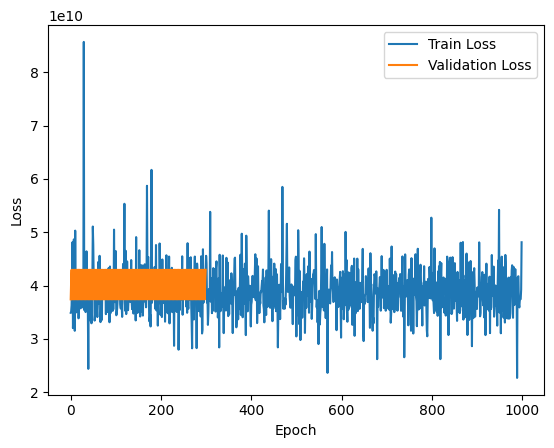

In [319]:


plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()